# Gmail data analysis
### Exploring more than 5 years of Gmail messages

I learned recently that Google allows its users to download metadata for all the messages sent and received through Gmail. This leads to interesting insights to be found in the data: *What are the most common people I have been in touch with? What days of the week or time of the day have the highest trafic?* In order to explore these and other questions I decided to request my data and perform the present analysis.

The first step is [requesting the data](https://takeout.google.com/settings/takeout). There is data available for several Google services, only the Gmail data is used here. Depending on the amount of data the request can take several hours (my file is 1.2GB). Once we are notified that the file is ready to be downloaded, the data will come in a special format called `mailbox`. After importing some useful modules we can clean and explore the data.

## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import mailbox
import pandas as pd
import csv
import unicodedata
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})

# For better quality plots use
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from time import time
from collections import Counter

<ipython-input-2-036d9073cc2f>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## Data preprocessing
One of the most important steps before analyzing the data is its proper cleaning, which refers to removing unnecessary data, dealing with missing values, grouping fields that appear different for the machine but that refer to the same items, etc.
We begin by saving the data file `gmail_data.mbox` in a directory called `data` (for privacy reasons, this file is absent from the GitHub repository). The file can be loaded using the `mailbox` module

In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Self practice projects/Gmail/All mail Including Spam and Trash.mbox'
mbox = mailbox.mbox(file_path)
print('samples:', len(mbox))

samples: 14601


The file contains 14601 samples. Even though these are mostly email messages, many other entry types are counted, such as drafts and chats. These can be removed by filtering by Gmail label. The file contains the following fields

In [4]:
# print fields
for i, key in enumerate(mbox[0].keys()):
    print(i+1, key)

1 X-GM-THRID
2 X-Gmail-Labels
3 Delivered-To
4 Received
5 X-Google-Smtp-Source
6 X-Received
7 ARC-Seal
8 ARC-Message-Signature
9 ARC-Authentication-Results
10 Return-Path
11 Received
12 Received-SPF
13 Authentication-Results
14 Return-Path
15 DKIM-Signature
16 X-MSFBL
17 Received
18 From
19 Subject
20 Date
21 To
22 Reply-To
23 MIME-Version
24 X-mailer
25 Message-ID
26 List-Unsubscribe
27 Content-Type


We find that there are several section of little interest. In order to avoid loading unnecessary information, we can extract the fields of interest and put them into a `pandas` dataframe for further processing. We are interested in the following fields: `subject`, `from`, `to`, `date`, and `Gmail-label`.

In [5]:
t0 = time()
subject = []
from_ = []
to = []
date = []
label = []
for i, message in enumerate(mbox):
    try:
        if i%2000 == 0:
            print(i, end=' ')
        subject.append(message['subject'])
        from_.append(message['from'])
        to.append(message['to'])
        date.append(message['date'])
        label.append(message['X-Gmail-Labels'])
    except:
        print(i, end=' ')
        print('subject', subject[i])
        print('from', from_[i])
        print('to', to[i])
        print('date', date[i])
        print('label', label[i])
print('\ntime: {:.1f} min'.format((time()-t0)/60))

0 2000 4000 6000 8000 10000 12000 14000 
time: 0.7 min


In [6]:
df = pd.DataFrame()
df['subject'] = subject
df['from'] = from_
df['to'] = to
df['date'] = date
df['label'] = label

In [7]:
df[['subject', 'date', 'label']].head()

,subject,date,label
0,=?windows-1252?Q?Here=92s_a_smart_way_to_inves...,"Wed, 12 Apr 2023 22:31:37 +0800","Inbox,Category Updates"
1,"Jaykumar, your application was sent to Fero Pa...","Sat, 15 Apr 2023 03:17:12 +0000 (UTC)","Inbox,Important,Category Updates"
2,Grow Your Earnings on Fiverr,"Thu, 13 Apr 2023 03:32:10 +0000 (UTC)","Inbox,Category Promotions"
3,Take advantage of BITS Pilani's open eligibili...,"Fri, 14 Apr 2023 10:23:42 -0600","Inbox,Category Promotions"
4,=?utf-8?B?VGltZSB0byBsZXZlbCB1cCDwn5SdIFlvdXIg...,"Sat, 15 Apr 2023 05:30:21 +0000","Inbox,Category Updates"


My Gmail data contains mostly messages in English; however, there is plenty of Spanish and German, which introduce special characters that can lead to encoding issues. For this reason, it is better to encode special characters such as `ñ` and letters with accents and umlauts

In [8]:
def remove_accents(text):
    text = str(text)
    nfkd_norm = unicodedata.normalize('NFKD', text)
    text = nfkd_norm.encode('ASCII', 'ignore').decode('utf-8')
    return text

In [9]:
df['subject'] = df['subject'].map(remove_accents)

After cleaning the `subject` field, we can get a general overview of the integrity of different fields

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14601 entries, 0 to 14600
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  14601 non-null  object
 1   from     14601 non-null  object
 2   to       14592 non-null  object
 3   date     14601 non-null  object
 4   label    14601 non-null  object
dtypes: object(5)
memory usage: 570.5+ KB


We find that `to`, one of the most relevant fields, contains some null entries. Which has to be removed.

In [11]:
len(df[df['to'].isnull()])

9

In [12]:
# delete null rows
df = df[df['to'].notnull()]
len(df)

14592

The next goal is to transform the class type: dates are given as strings

In [13]:
df[['date']].head()

,date
0,"Wed, 12 Apr 2023 22:31:37 +0800"
1,"Sat, 15 Apr 2023 03:17:12 +0000 (UTC)"
2,"Thu, 13 Apr 2023 03:32:10 +0000 (UTC)"
3,"Fri, 14 Apr 2023 10:23:42 -0600"
4,"Sat, 15 Apr 2023 05:30:21 +0000"


These string dates can be converted into timestamps using the converted available for dataframes

In [14]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

Some dates have unappropriate shape for conversion (these are drafts of spam messages), which can be simply removed

In [15]:
df = df[df['date'].notnull()]

Given that the date is now a timestamp, messages can be easily sorted by date, after which the dataframe index must be reset

In [16]:
df = df.sort_values(['date'], ascending=False)
df = df.reset_index(drop=True)

The most recent messages are the following

In [17]:
df[['subject', 'date', 'label']].head(8)

,subject,date,label
0,Aadhaar XXXX XXXX 9211: Authentication Succes...,2023-04-15 05:48:59+00:00,"Inbox,Important,Opened,Category Personal"
1,Aadhaar XXXX XXXX 9211: Authentication Succes...,2023-04-15 05:47:00+00:00,"Inbox,Important,Opened,Category Updates"
2,=?UTF-8?Q?There=E2=80=99s_a_connection_request...,2023-04-15 05:46:47+00:00,"Inbox,Opened,Category Social"
3,=?utf-8?B?VGltZSB0byBsZXZlbCB1cCDwn5SdIFlvdXIg...,2023-04-15 05:30:21+00:00,"Inbox,Category Updates"
4,=?UTF-8?Q?Tyke_Digest_-_Elon_Musk_to_Challenge...,2023-04-15 05:10:51+00:00,"Inbox,Category Updates"
5,View: Account update for your HDFC Bank A/c,2023-04-15 05:00:21+00:00,"Inbox,Important,Opened,Category Updates"
6,Aye Finance is coming again with Aye Finance A...,2023-04-15 04:56:18+00:00,"Inbox,Important,Category Updates"
7,Bourge Men's Loire-z3 Running...,2023-04-15 03:19:06+00:00,"Inbox,Category Promotions"


where the most recent message is the notification from Gmail to download the data used here. The oldest messages are

In [18]:
df[['subject', 'date', 'label']].tail(9)

,subject,date,label
14543,,2020-07-17 10:51:17+00:00,"Archived,Sent,Opened"
14544,pdf,2020-07-17 08:43:52+00:00,"Archived,Sent,Opened"
14545,,2020-07-07 13:41:33+00:00,"Archived,Sent,Opened"
14546,Re:,2020-07-06 18:44:57+00:00,"Sent,Opened"
14547,,2020-06-28 09:56:17+00:00,"Archived,Sent,Opened"
14548,pdf,2020-06-23 08:53:39+00:00,"Archived,Sent,Opened"
14549,pdf,2020-06-22 10:25:34+00:00,"Archived,Sent,Opened"
14550,pdf,2020-06-22 09:17:04+00:00,"Archived,Sent,Opened"
14551,pdf,2020-06-22 05:33:05+00:00,"Archived,Sent,Opened"


Finally, there are many messages in the `Drafts` folder that should also be removed

In [19]:
df = df[df['label'] != 'Drafts']

The same applies for `Spam` messages. Unfortunately, this label does not appear alone so it must be searched in the `label` column

In [20]:
cnt = 0
idx_to_remove = []
for i, lab in enumerate(df['label']):
    if 'Spam' in str(lab):
        idx_to_remove.append(i)
        
df = df.drop(df.index[idx_to_remove])
df = df.reset_index(drop=True)

At this point, and given the time used for cleaning the data file, it is a good idea to export it as a `csv` file for future use without the need of redoing the preprocessing above.

In [21]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Self practice projects/Gmail/gmail_data_preprocessed.csv', 
          encoding='utf-8', index=False)

# **Data exploration**

We can now begin exploring the data set.

In [22]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Self practice projects/Gmail/gmail_data_preprocessed.csv')
len(df)

14535

Since the data was loaded from a `csv` file, the dates are back as `str` so they must be converted into `timestamp` again

In [23]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

## **1. Incoming vs. outgoing messages**
For simplicity, all messages written by me or sent to me can be labeled by the string `me` instead of my email address. This will make the identification of incoming and outgoing emails easier. For this the following helper function returns `me` my email address is found and leaves the text unchanged, otherwise:

In [24]:
def rename_me(txt):
    txt = str(txt).lower()
    if('jaykumar' in txt or
       '25012001' in txt):
        txt_out = 'me'
    else:
        txt_out = txt
    return txt_out

In [25]:
df['from'] = df['from'].apply(rename_me)
df['to'] = df['to'].apply(rename_me)

In [26]:
df[['subject', 'to', 'date', 'label']].head(4)

,subject,to,date,label
0,Aadhaar XXXX XXXX 9211: Authentication Succes...,me,2023-04-15 05:48:59+00:00,"Inbox,Important,Opened,Category Personal"
1,Aadhaar XXXX XXXX 9211: Authentication Succes...,me,2023-04-15 05:47:00+00:00,"Inbox,Important,Opened,Category Updates"
2,=?UTF-8?Q?There=E2=80=99s_a_connection_request...,me,2023-04-15 05:46:47+00:00,"Inbox,Opened,Category Social"
3,=?utf-8?B?VGltZSB0byBsZXZlbCB1cCDwn5SdIFlvdXIg...,me,2023-04-15 05:30:21+00:00,"Inbox,Category Updates"


Since we want to explore the statistical distribution of messages, a useful information is a count of messages, for which a unit `count` column can be created

In [27]:
df['count'] = [1 for _ in range(len(df))]

In order to keep the original data intact, we can make a copy and set the timestamp as a index, so that messages can be grouped and resampled by time periods

In [28]:
data = df.copy()
data.set_index('date', drop=True, inplace=True)

Now we can identify incoming vs. outgoing emails 

In [29]:
data_in = data[data['to'] == 'me']
data_out = data[data['from'] == 'me']

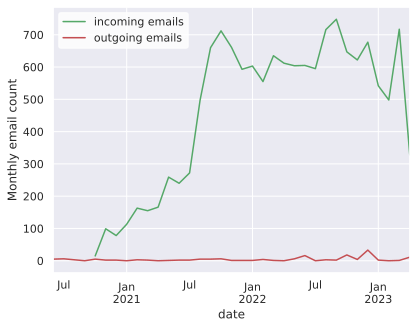

In [30]:
monthly_in = data_in['count'].resample('M').sum()
monthly_out= data_out['count'].resample('M').sum()
monthly_in.plot(color='g', label='incoming emails')
monthly_out.plot(color='r', label='outgoing emails')
plt.ylabel('Monthly email count')
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white');

It can be seen that most of the time the number of received emails is greater than the number of emails sent.

## **2. Busy days**

We can now try to identify email activity vs. day of the week. We use the `timestamp` method `weekday()`, which returns an index [0....6] corresponding to the days of the from Monday to Sunday.

In [31]:
dow = []
for i in range(len(df)):
    dow.append(df['date'][i].weekday())

Create new `series` with the day of the week of the message

In [32]:
df['dow'] = dow
df[['subject', 'date', 'dow', 'label']].head(4)

,subject,date,dow,label
0,Aadhaar XXXX XXXX 9211: Authentication Succes...,2023-04-15 05:48:59+00:00,5,"Inbox,Important,Opened,Category Personal"
1,Aadhaar XXXX XXXX 9211: Authentication Succes...,2023-04-15 05:47:00+00:00,5,"Inbox,Important,Opened,Category Updates"
2,=?UTF-8?Q?There=E2=80=99s_a_connection_request...,2023-04-15 05:46:47+00:00,5,"Inbox,Opened,Category Social"
3,=?utf-8?B?VGltZSB0byBsZXZlbCB1cCDwn5SdIFlvdXIg...,2023-04-15 05:30:21+00:00,5,"Inbox,Category Updates"


In [33]:
df_in = df[df['to'] == 'me']
df_out = df[df['from'] == 'me']

We can now get the distribution of messages per day of the week. For this a dictionary can easily capture the frequency of messages on each day

In [34]:
dow_in, dow_out = {}, {}
for i in range(7):
    dow_in[i] = 0
    dow_out[i] = 0
for i in df_in['dow']:
    dow_in[i] += 1
for i in df_out['dow']:
    dow_out[i] += 1

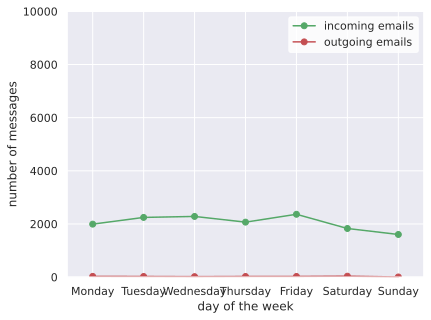

In [35]:
x, y_in, y_out, y_all = [], [], [], []
for key in dow_in.keys():
    x.append(key)
    y_in.append(dow_in[key])
    y_out.append(dow_out[key])
    y_all.append(dow_in[key] + dow_out[key])

plt.plot(x, y_in, 'o-', color='g', label='incoming emails')
plt.plot(x, y_out, 'o-', color='r', label='outgoing emails')
plt.axis([-0.5, 6.5, 0, 10000])
plt.xlabel('day of the week')
plt.ylabel('number of messages')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(x, days)
plt.legend(frameon=True).get_frame().set_color('white');

This plot shows clearly that the activity is quite uniform during the week days and it decreases during the weekens, as sort of expected.

## **3. Frequent contacts**
Another immediate question that can be answered with this data is regarding the most frequent contacts I have received messages from and those to whom I have written the most. Just as done earlier with my email address that was replaced by the string `me`.

***For the privacy of my contacts (I prefer not to post their email address) can be protected by creating a function that can replace their contact information with a nickname.***

In [36]:
def nickname(txt, list_to_rename, new_name):
    txt = str(txt)
    for name in list_to_rename:
        if name in txt.lower():
            txt_out = new_name
            break
        else:
            txt_out = txt
    return txt_out

where `txt` is the text where the names on the list `list_to_rename` are been searched, if found they will be replaced by the nickname `new_name`.This is done for a few frequent contacts.

In [37]:
df['to'] = df['to'].apply(lambda x: nickname(x, ['krutik'], 'krutik'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['sakshi'], 'sakshi'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['agney'], 'agney'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['desai'], 'kishan'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['meet'], 'meet'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['meko'], 'meko'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['place'], 'university'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['gujuni'], 'guj university'))

The most frequent contacts that I have written to are

In [38]:
df['to'].value_counts()[1:10]

sakshi                      22
krutik                      17
guj university              12
meko                        10
agney                        6
kishan                       6
meet                         6
university                   5
undisclosed-recipients:;     4
Name: to, dtype: int64

This shows the count of emails which were sent. All these results can be visualized

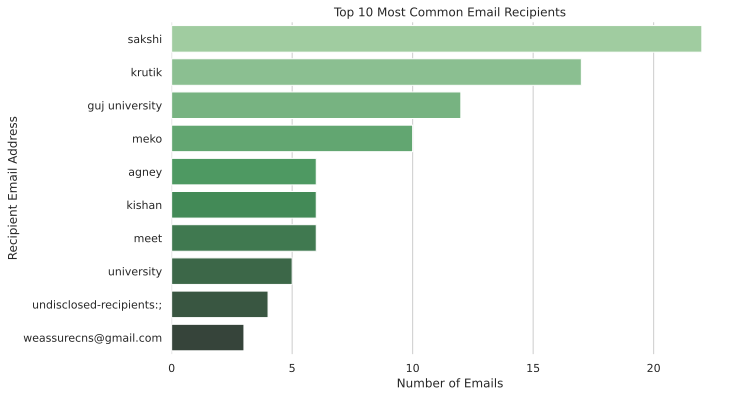

In [39]:
df_top10 = df['to'].value_counts()[1:11].reset_index()
df_top10.columns = ['to', 'count']

sns.set_style("whitegrid")
sns.set_color_codes("pastel")
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='to', data=df_top10, palette='Greens_d')
plt.title('Top 10 Most Common Email Recipients')
plt.xlabel('Number of Emails')
plt.ylabel('Recipient Email Address')

sns.despine(left=True, bottom=True)
plt.show()


Now we can check from whom i received most number of emails. But the problem with the from email is duplicate email IDs. *`Eg - no-reply@ncp.flipkart.com and no-reply@ncb.flipkart.com`* they both are same but if we count the number of 
emails both the email IDs will show seperate counts. So for this we can create 
nicknames just the way we created for sent mails.

In [58]:
df['from'] = df['from'].apply(lambda x: nickname(x, ['hdfc'], 'hdfc'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['linkedin'], 'linkedin'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['angel'], 'angel'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['indeed'], 'indeed'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['phonepe'], 'phonepe'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['instagram'], 'instagram'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['myntra'], 'myntra'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['flipkart'], 'flipkart'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['quora'], 'quora'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['kotak'], 'kotak'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['citi'], 'citi bank'))

In [59]:
df['from'].value_counts()[1:8]

phonepe      1401
kotak        1155
hdfc         1143
indeed        798
angel         642
flipkart      585
instagram     506
Name: from, dtype: int64

This shows the count of emails which were received. All these results can be visualized

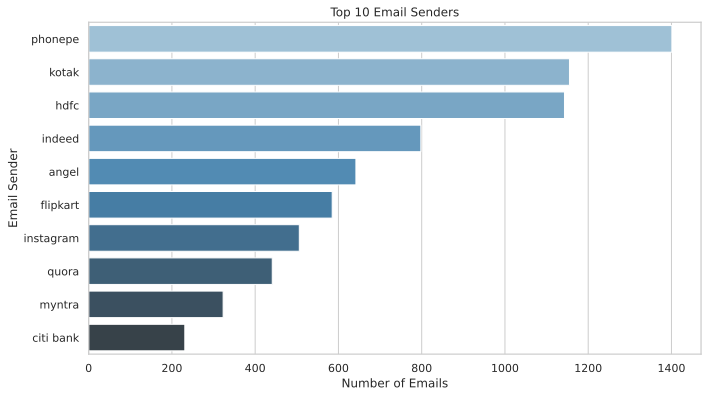

In [60]:
df_top7 = df['from'].value_counts()[1:11]
sns.set_style('whitegrid')
plt.figure(figsize=(11,6))
sns.barplot(x=df_top7, y=df_top7.index, palette='Blues_d')
plt.xlabel('Number of Emails')
plt.ylabel('Email Sender')
plt.title('Top 10 Email Senders')
plt.show()

### 4. Most common topics
The content of the messages is unavailable; however, the subject of each message can clearly indicate the recurrent topics for both incoming and outgoing emails. which can be visualized in word cloud.

In [43]:
all_wrds_in = []
for wrds in list(df['subject'][df['to'] == 'me']):
    all_wrds_in.extend(str(wrds).lower().split())
    
all_wrds_out = []
for wrds in list(df['subject'][df['from'] == 'me']):
    all_wrds_out.extend(str(wrds).lower().split())

In [44]:
all_wrds_in[:6]

['aadhaar', 'xxxx', 'xxxx', '9211:', 'authentication', 'successful']

In [45]:
my_stopwords = ['re:', 'nan', 'none', '-', 'fwd:', 'fw:', 
                '&', 'hola', 'saludos', 'order', 'amazon.com']

In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
from nltk.corpus import stopwords
stopwords_en = set(stopwords.words('english'))
all_stopwords = stopwords_en | set(my_stopwords)

In [48]:
len(all_wrds_in), len(all_wrds_out)

(83215, 415)

In [49]:
all_wrds_in = [wrd for wrd in all_wrds_in if wrd not in all_stopwords]
all_wrds_out = [wrd for wrd in all_wrds_out if wrd not in all_stopwords]

In [50]:
len(all_wrds_in), len(all_wrds_out)

(63304, 315)

In [51]:
wrds_in = Counter(all_wrds_in)
wrds_out = Counter(all_wrds_out)

In [52]:
wrds_in.most_common(10)

[('new', 1339),
 ('jobs', 1000),
 ('bank', 943),
 ('account', 917),
 ('hdfc', 679),
 ('update', 662),
 ('a/c', 612),
 ('view:', 608),
 ('job', 528),
 ('|', 482)]

In [53]:
wrds_out.most_common(10)

[('opportunity', 11),
 ('inquiry', 10),
 ('regarding', 10),
 ('job', 10),
 ('mentioned', 10),
 ('fiver', 10),
 ('ggg', 7),
 ('views', 6),
 ('resume', 6),
 ('assignment', 5)]

In [54]:
from wordcloud import WordCloud, STOPWORDS

In [55]:
words_in = ''
for t in wrds_in.most_common(150):
    for i in range(t[1]):
        words_in += t[0] + ' '
        
words_out = ''
for t in wrds_out.most_common(150):
    for i in range(t[1]):
        words_out += t[0] + ' '

# **Word cloud of incoming mails**

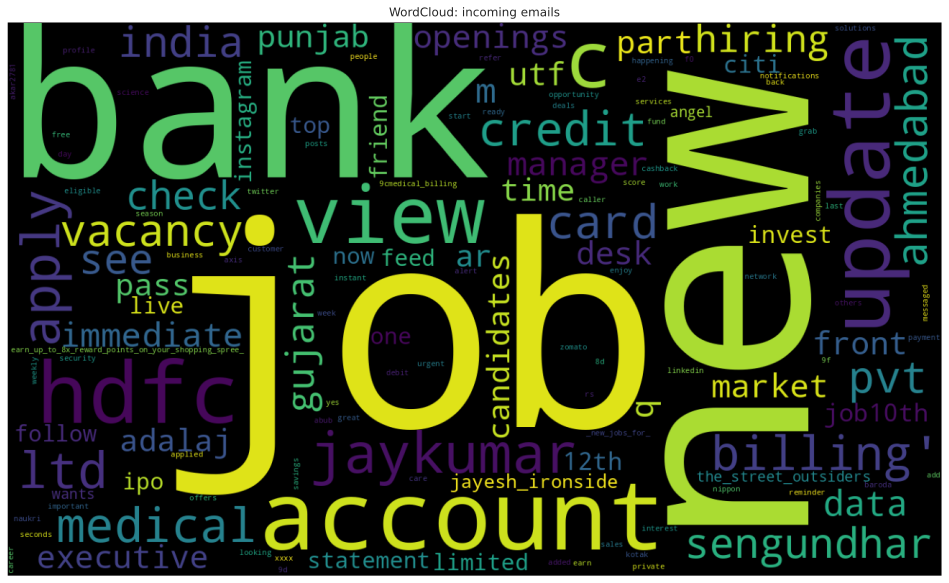

In [56]:
wordcloud_in = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1350, height=800,
                      collocations=False
                     ).generate(words_in)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_in)
plt.axis('off')
plt.title('WordCloud: incoming emails');

# **Word cloud of outgoing mails**

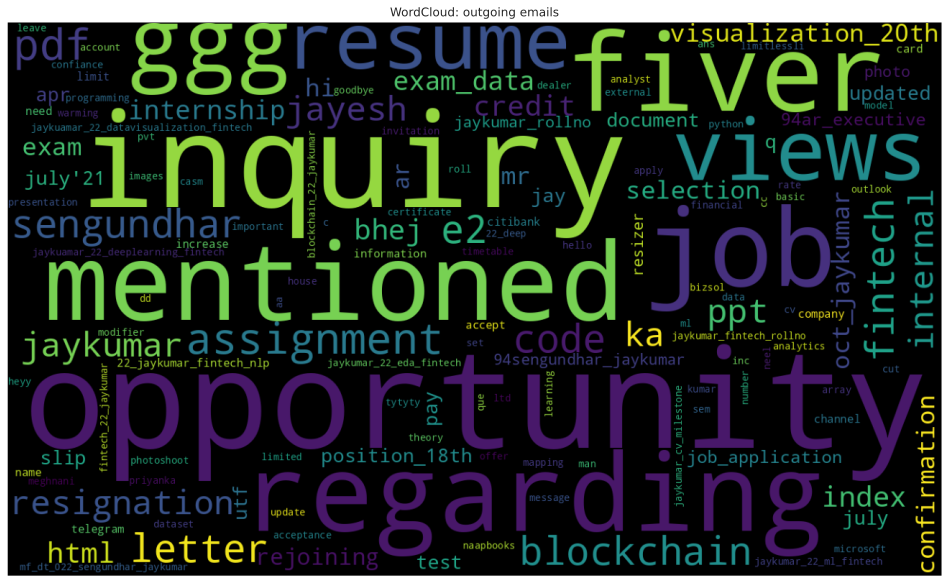

In [57]:
wordcloud_out = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1350, height=800,
                      collocations=False
                     ).generate(words_out)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_out)
plt.axis('off')
plt.title('WordCloud: outgoing emails');